In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
atc = pd.read_csv('atc.csv')
depth_charts = pd.read_csv('depth_charts.csv')
steamer = pd.read_csv('steamer.csv')
bat = pd.read_csv('the_bat.csv')
zips = pd.read_csv('zips.csv')

In [3]:
# Filter and rename ERA columns for each dataset
def filter_era(df, system_name):
    df = df[['PlayerId', 'Name', 'Team', 'ERA']]
    df.columns = ['PlayerId', 'Name', 'Team', f'{system_name}_ERA']
    return df

atc_filtered = filter_era(atc, 'ATC')
depth_charts_filtered = filter_era(depth_charts, 'Depth_Charts')
steamer_filtered = filter_era(steamer, 'Steamer')
bat_filtered = filter_era(bat, 'The_BAT')
zips_filtered = filter_era(zips, 'ZiPS')

# Concatenating the dataframes with an outer join to ensure all players are included
projection_dfs = [atc_filtered, depth_charts_filtered, steamer_filtered, bat_filtered, zips_filtered]
all_projections = pd.concat(projection_dfs)

# Grouping by player and aggregating the data
grouped_projections = all_projections.groupby(['PlayerId', 'Name', 'Team']).mean().reset_index()

grouped_projections.head()



,PlayerId,Name,Team,ATC_ERA,Depth_Charts_ERA,Steamer_ERA,The_BAT_ERA,ZiPS_ERA
0,10058,Tyler Matzek,ATL,4.17265,4.29046,4.38093,5.19065,4.20000
1,10061,Brooks Raley,NYM,3.81405,4.15065,3.90129,4.49057,4.40000
2,10078,Caleb Thielbar,MIN,3.68747,3.77880,3.60638,3.93078,3.95122
3,10123,Kyle Gibson,STL,4.48121,4.40941,4.31410,4.76991,4.50902
4,10131,Stephen Strasburg,WSN,NaN,NaN,4.98141,NaN,4.03135


In [114]:
# Load the MLB data
mlb_data = pd.read_csv('mlb_new_021324.csv')

# Filter MLB data for ERA lines
era_lines = mlb_data[mlb_data['Market Name'].str.contains('ERA')]

# Extract player names from the 'Market Name' column
era_lines['Player Name'] = era_lines['Market Name'].str.extract(' - (.*) ERA')

# Join the ERA lines with the projections
# Merging on 'Name' from projections and 'Player Name' from era_lines
final_data = pd.merge(era_lines, grouped_projections, left_on='Player Name', right_on='Name', how='left')

final_data = final_data[~(final_data['The_BAT_ERA']).isna()]
final_data.head()



/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_35250/2337861830.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  era_lines['Player Name'] = era_lines['Market Name'].str.extract(' - (.*) ERA')


,Market Name,Outcome,Bet Price,Player Name,PlayerId,Name,Team,ATC_ERA,Depth_Charts_ERA,Steamer_ERA,The_BAT_ERA,ZiPS_ERA
0,Arizona Diamondbacks - Zac Gallen ERA,Over 3.35,-125,Zac Gallen,19291,Zac Gallen,ARI,3.64813,3.70050,3.82357,3.87008,3.57488
1,Arizona Diamondbacks - Zac Gallen ERA,Under 3.35,-105,Zac Gallen,19291,Zac Gallen,ARI,3.64813,3.70050,3.82357,3.87008,3.57488
2,Atlanta Braves - Spencer Strider ERA,Over 3.05,-115,Spencer Strider,27498,Spencer Strider,ATL,3.38062,3.23170,3.18216,3.21003,3.28386
3,Atlanta Braves - Spencer Strider ERA,Under 3.05,-115,Spencer Strider,27498,Spencer Strider,ATL,3.38062,3.23170,3.18216,3.21003,3.28386
4,Baltimore Orioles - Corbin Burnes ERA,Over 3.30,-125,Corbin Burnes,19361,Corbin Burnes,BAL,3.51893,3.52049,3.71614,3.69019,3.31844


In [115]:
# Filter the final data to include only 'Over' outcomes
over_lines = final_data[final_data['Outcome'].str.contains('Over')]
over_lines = over_lines.copy()
# Extracting the numerical value from the 'Outcome' column (e.g., "Over 3.35" -> 3.35)
over_lines['Over_Value'] = over_lines['Outcome'].str.extract('Over (.*)').astype(float)

# Calculating the mean projection ERA for each player
over_lines['Mean_Projection_ERA'] = over_lines[['ATC_ERA', 'Depth_Charts_ERA', 'Steamer_ERA', 'The_BAT_ERA', 'ZiPS_ERA']].mean(axis=1)

# Calculating the difference between the projection and the line
over_lines['Difference'] = over_lines['Mean_Projection_ERA'] - over_lines['Over_Value']



In [116]:
# Calculating the mean and median of the projections in separate columns
over_lines['Mean_Projection_ERA'] = over_lines[['ATC_ERA', 'Depth_Charts_ERA', 'Steamer_ERA', 'The_BAT_ERA', 'ZiPS_ERA']].mean(axis=1)
over_lines['Median_Projection_ERA'] = over_lines[['ATC_ERA', 'Depth_Charts_ERA', 'Steamer_ERA', 'The_BAT_ERA', 'ZiPS_ERA']].median(axis=1)
over_lines['med_diff'] = over_lines['Median_Projection_ERA'] - over_lines['Over_Value']
over_lines['mean_diff'] = over_lines['Mean_Projection_ERA'] - over_lines['Over_Value']
# Shortening player names to format 'Z. Gallen'
over_lines['Shortened_Name'] = over_lines['Player Name'].str.split().apply(lambda x: f"{x[0][0]}. {' '.join(x[1:])}")


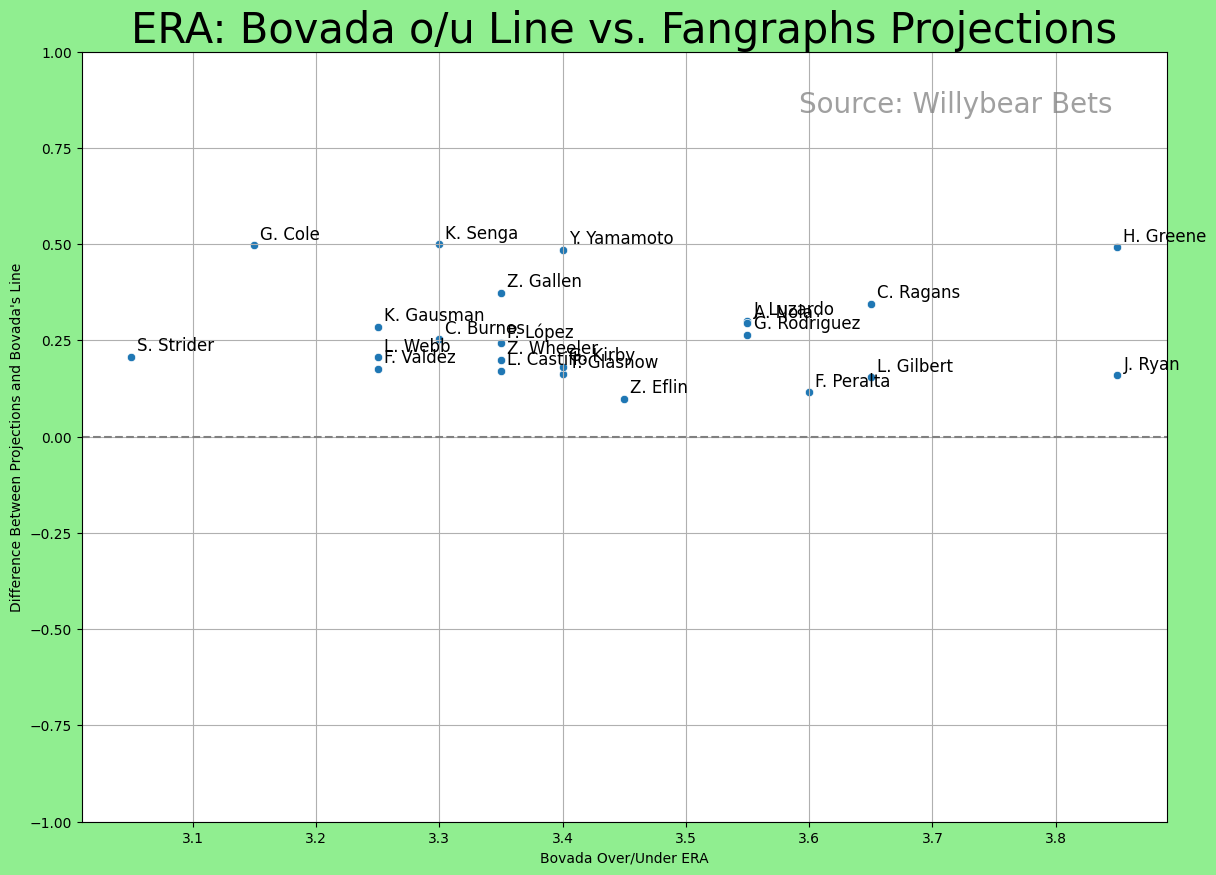

In [117]:
# Adjusting the plot to be horizontal for better visualization of differentials
plt.figure(figsize=(14, 10), facecolor='lightgreen')
sns.scatterplot(data=over_lines, y='mean_diff', x='Over_Value')
plt.title('ERA: Bovada o/u Line vs. Fangraphs Projections', fontsize = 30)
plt.ylabel("Difference Between Projections and Bovada's Line")
plt.xlabel('Bovada Over/Under ERA')
plt.ylim(-1, 1)
plt.axhline(0, color='grey', ls='--')  # Adding a horizontal reference line at y=0
plt.grid(True)
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)
# Annotating each point with the player's shortened name
for index, row in over_lines.iterrows():
    plt.text(row['Over_Value'] + .005, row['mean_diff'] +.005, row['Shortened_Name'], verticalalignment='bottom', size='large', color='black')

plt.show()

In [84]:
# Load in the ESPN data

espn = pd.read_csv('espn_2024_pitching.csv')

In [85]:
espn_overs = over_lines.merge(espn, left_on = 'Player Name', right_on = 'Name', how = 'left')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


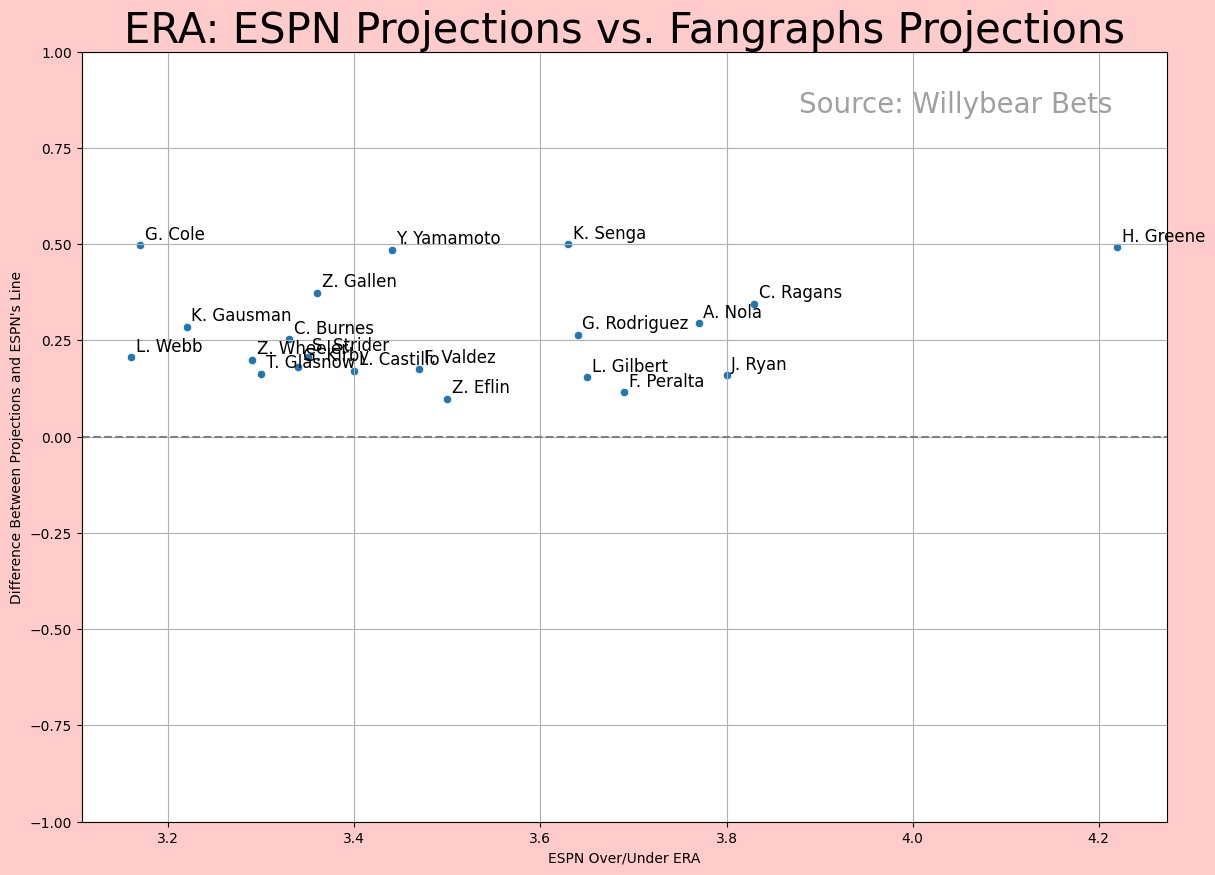

In [86]:
# Adjusting the plot to be horizontal for better visualization of differentials
plt.figure(figsize=(14, 10), facecolor='#ffcccb')
sns.scatterplot(data=espn_overs, y='mean_diff', x='ERA')
plt.title('ERA: ESPN Projections vs. Fangraphs Projections', fontsize = 30)
plt.ylabel("Difference Between Projections and ESPN's Line")
plt.xlabel('ESPN Over/Under ERA')
plt.ylim(-1, 1)
plt.axhline(0, color='grey', ls='--')  # Adding a horizontal reference line at y=0
plt.grid(True)
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)
# Annotating each point with the player's shortened name
for index, row in espn_overs.iterrows():
    plt.text(row['ERA'] + .005, row['mean_diff'] +.005, row['Shortened_Name'], verticalalignment='bottom', size='large', color='black')


plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


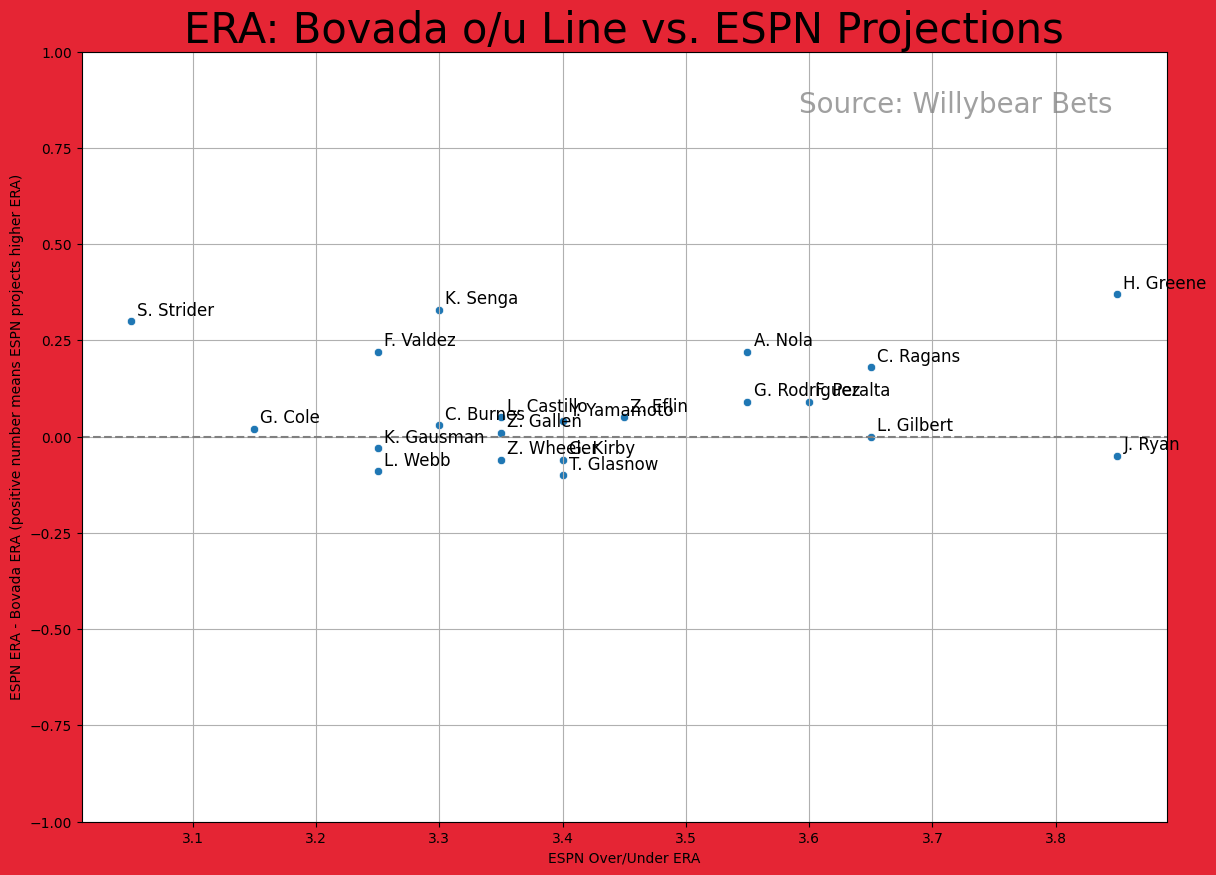

In [87]:
espn_overs['espn_diff'] = espn_overs['ERA'] - espn_overs['Over_Value']
# Adjusting the plot to be horizontal for better visualization of differentials
plt.figure(figsize=(14, 10), facecolor='#e52534')
sns.scatterplot(data=espn_overs, y='espn_diff', x='Over_Value')
plt.title('ERA: Bovada o/u Line vs. ESPN Projections', fontsize = 30)
plt.ylabel("ESPN ERA - Bovada ERA (positive number means ESPN projects higher ERA)")
plt.xlabel('ESPN Over/Under ERA')
plt.ylim(-1, 1)
plt.axhline(0, color='grey', ls='--')  # Adding a horizontal reference line at y=0
plt.grid(True)
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)
# Annotating each point with the player's shortened name
for index, row in espn_overs.iterrows():
    plt.text(row['Over_Value'] + .005, row['espn_diff'] +.005, row['Shortened_Name'], verticalalignment='bottom', size='large', color='black')

plt.show()

In [88]:
yahoo = pd.read_csv('yahoo_2024_pitching.csv')
yahoo_overs = espn_overs.merge(yahoo, left_on = 'Player Name', right_on = 'Name', how = 'left')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


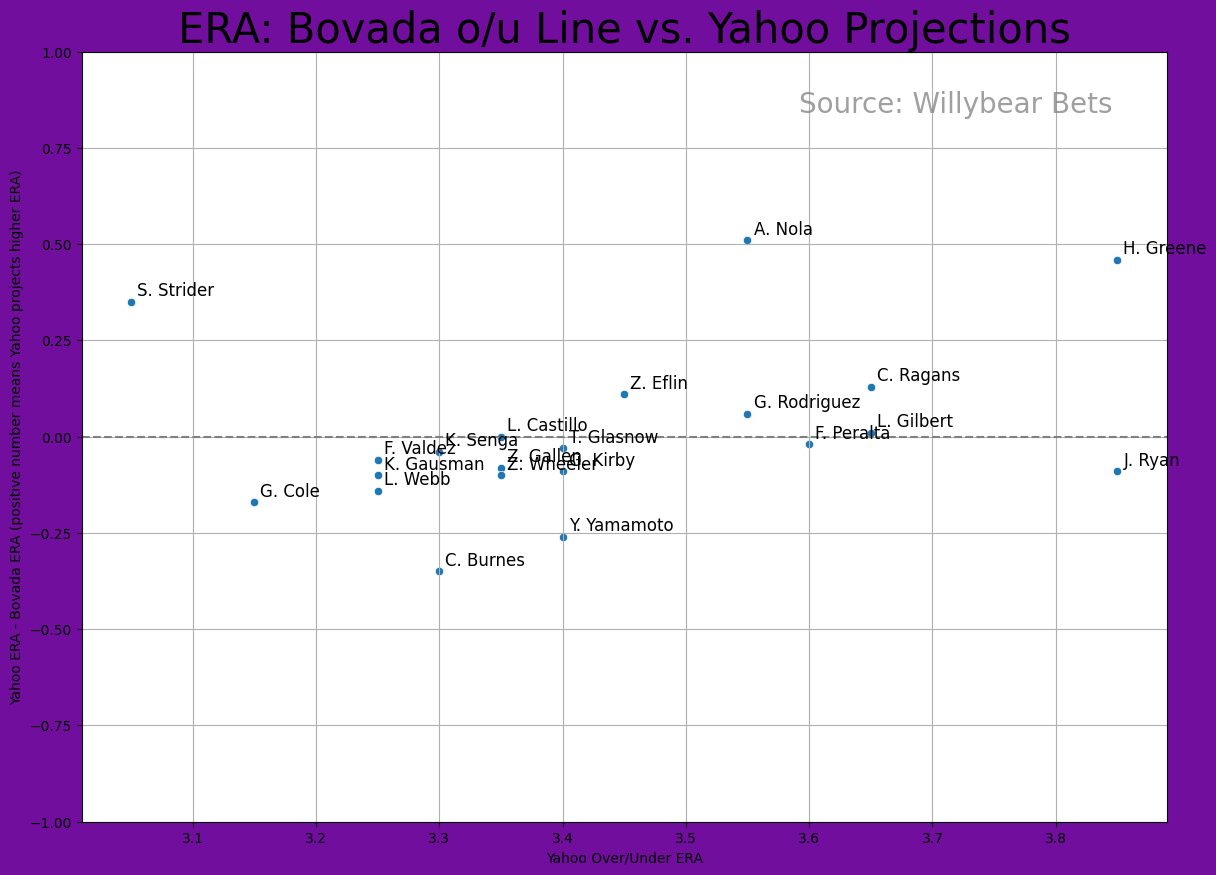

In [89]:
yahoo_overs['yahoo_diff'] = yahoo_overs['ERA_y'] - yahoo_overs['Over_Value']
# Adjusting the plot to be horizontal for better visualization of differentials
plt.figure(figsize=(14, 10), facecolor='#720e9e')
sns.scatterplot(data=yahoo_overs, y='yahoo_diff', x='Over_Value')
plt.title('ERA: Bovada o/u Line vs. Yahoo Projections', fontsize = 30)
# plt.title('Difference Between Yahoo ERA Line and Bovada Projections ERA\nSource: Fangraphs Projections: ATC, Depth Charts, The Bat, ZIPS, Steamer')
plt.ylabel("Yahoo ERA - Bovada ERA (positive number means Yahoo projects higher ERA)")
plt.xlabel('Yahoo Over/Under ERA')
plt.ylim(-1, 1)
plt.axhline(0, color='grey', ls='--')  # Adding a horizontal reference line at y=0
plt.grid(True)
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)
# Annotating each point with the player's shortened name
for index, row in yahoo_overs.iterrows():
    plt.text(row['Over_Value'] + .005, row['yahoo_diff'] +.005, row['Shortened_Name'], verticalalignment='bottom', size='large', color='black')

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


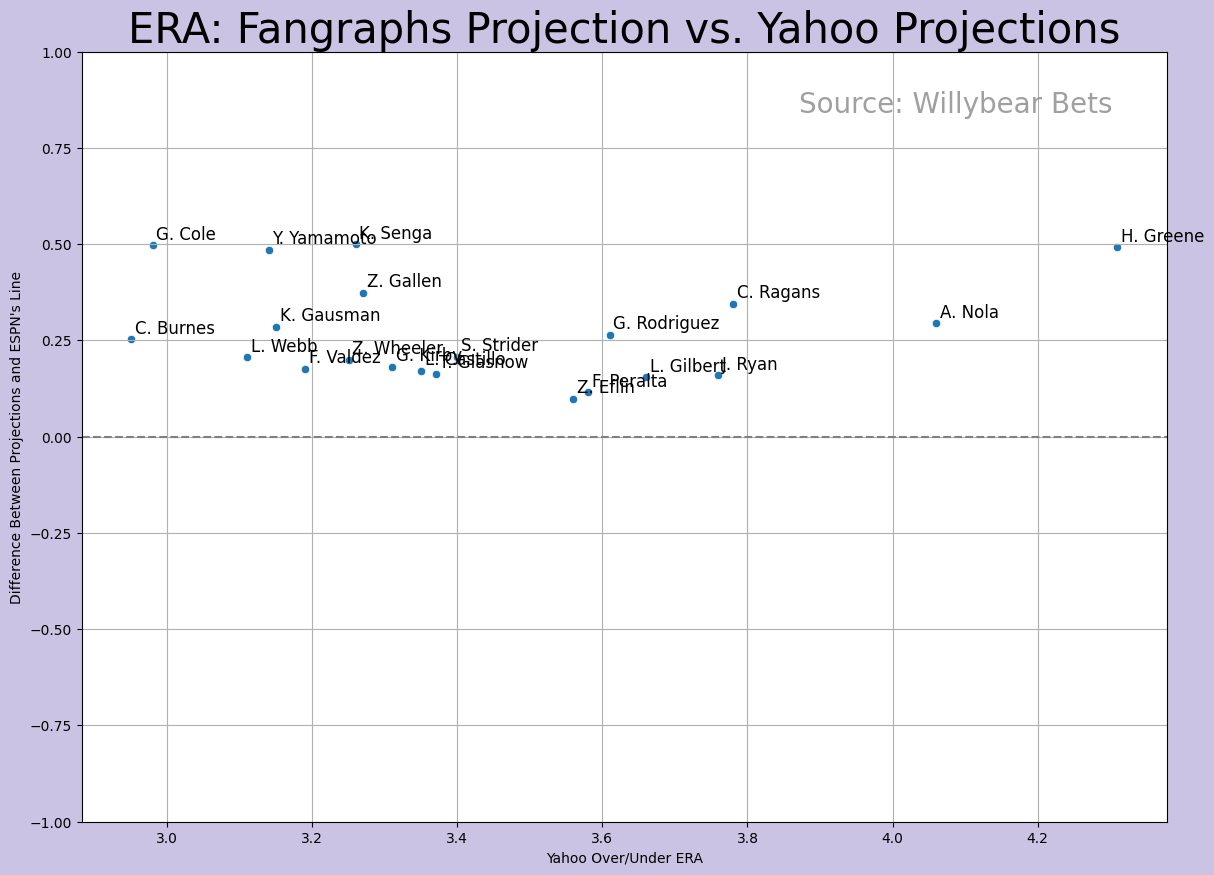

In [90]:
# Adjusting the plot to be horizontal for better visualization of differentials
plt.figure(figsize=(14, 10), facecolor='#CBC3E3')
sns.scatterplot(data=yahoo_overs, y='mean_diff', x='ERA_y')
plt.title('ERA: Fangraphs Projection vs. Yahoo Projections', fontsize = 30)
plt.ylabel("Difference Between Projections and ESPN's Line")
plt.xlabel('Yahoo Over/Under ERA')
plt.ylim(-1, 1)
plt.axhline(0, color='grey', ls='--')  # Adding a horizontal reference line at y=0
plt.grid(True)
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)
# Annotating each point with the player's shortened name
for index, row in yahoo_overs.iterrows():
    plt.text(row['ERA_y'] + .005, row['mean_diff'] +.005, row['Shortened_Name'], verticalalignment='bottom', size='large', color='black')


plt.show()

In [91]:
# Calculating the mean and median of the projections in separate columns
yahoo_overs['mean_era_2'] = yahoo_overs[['ATC_ERA', 'Depth_Charts_ERA', 'Steamer_ERA', 'The_BAT_ERA', 'ZiPS_ERA', 'ERA', 'ERA_y']].mean(axis=1)
# over_lines['Median_Projection_ERA'] = over_lines[['ATC_ERA', 'Depth_Charts_ERA', 'Steamer_ERA', 'The_BAT_ERA', 'ZiPS_ERA']].median(axis=1)
yahoo_overs['mean_diff_2'] = yahoo_overs['Mean_Projection_ERA'] - yahoo_overs['Over_Value']
# Shortening player names to format 'Z. Gallen'
over_lines['Shortened_Name'] = over_lines['Player Name'].str.split().apply(lambda x: f"{x[0][0]}. {' '.join(x[1:])}")


In [331]:
# # Adjusting the plot to be horizontal for better visualization of differentials
# plt.figure(figsize=(14, 10), facecolor='gold')
# sns.scatterplot(data=yahoo_overs, y='mean_diff', x='Over_Value')
# plt.title('Difference Between Bovada ERA Line and Consensus Projections ERA\nSource: Fangraphs Projections: ATC, Depth Charts, The Bat, ZIPS, Steamer AND ESPN, YAHOO')
# plt.ylabel("Difference Between Projections and Bovada's Line")
# plt.xlabel('Bovada Over/Under ERA')
# plt.ylim(-1, 1)
# plt.axhline(0, color='grey', ls='--')  # Adding a horizontal reference line at y=0
# plt.grid(True)

# # Annotating each point with the player's shortened name
# for index, row in yahoo_overs.iterrows():
#     plt.text(row['Over_Value'] + .005, row['mean_diff_2'] +.005, row['Shortened_Name'], verticalalignment='bottom', size='small', color='black', weight='semibold')

# plt.show()

In [92]:
yahoo_overs.to_csv('over_lines.csv')

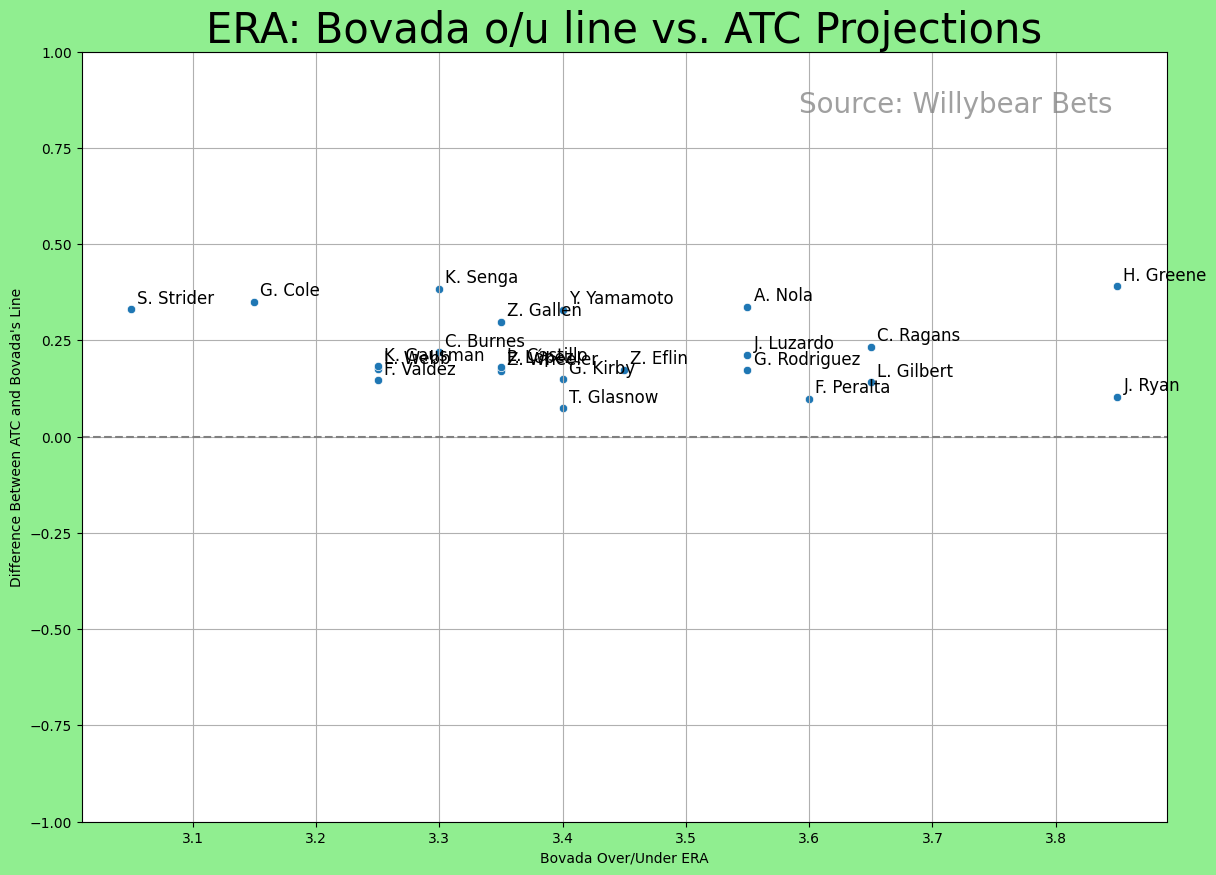

In [123]:
yahoo_overs['atc_diff'] = yahoo_overs['ATC_ERA'] - yahoo_overs['Over_Value']
# Adjusting the plot to be horizontal for better visualization of differentials
plt.figure(figsize=(14, 10), facecolor='lightgreen')
sns.scatterplot(data=yahoo_overs, y='atc_diff', x='Over_Value')
plt.title("ERA: Bovada o/u line vs. ATC Projections", fontsize = 30)
plt.ylabel("Difference Between ATC and Bovada's Line")
plt.xlabel('Bovada Over/Under ERA')
plt.ylim(-1, 1)
plt.axhline(0, color='grey', ls='--')  # Adding a horizontal reference line at y=0
plt.grid(True)
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)
# Annotating each point with the player's shortened name
for index, row in yahoo_overs.iterrows():
    plt.text(row['Over_Value'] + .005, row['atc_diff'] +.005, row['Shortened_Name'], verticalalignment='bottom', size='large', color='black')


plt.show()

# Lets analyze how off 2023 projections were vs 2023 actuals

In [94]:
patc = pd.read_csv('pitch_atc_23.csv')
mlb = pd.read_csv('mlb_2023_stats.csv')
mlb['PlayerId'] = mlb['PlayerId'].astype('str')

In [95]:
last_yr = patc.merge(mlb, on='Name', how = 'right', suffixes=['_projected', '_actual'])
last_yr['diff'] = last_yr['ERA_actual'] - last_yr['ERA_projected']
last_yr['Shortened_Name'] = last_yr['Name'].str.split().apply(lambda x: f"{x[0][0]}.{' '.join(x[1:])}")


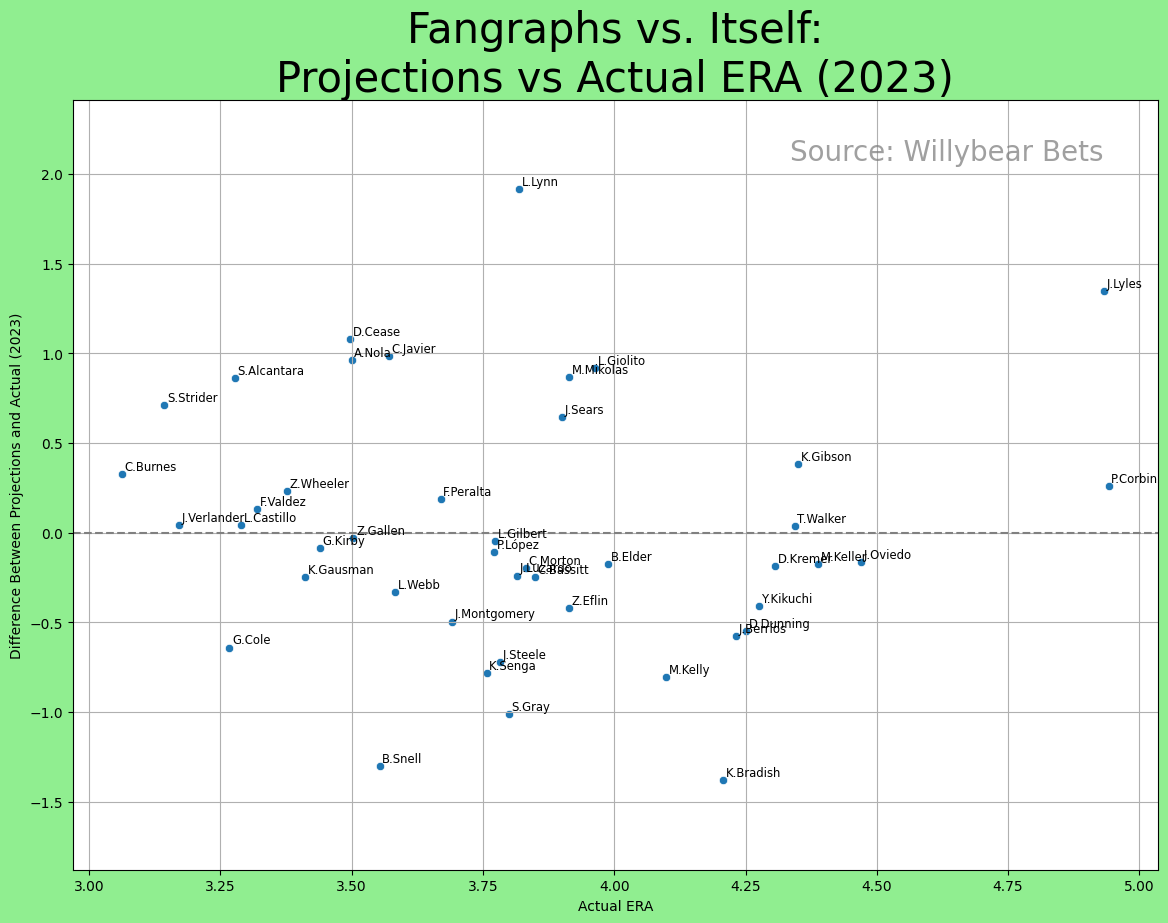

In [96]:
# Adjusting the plot to be horizontal for better visualization of differentials
plt.figure(figsize=(14, 10), facecolor='lightgreen')
sns.scatterplot(data=last_yr, y='diff', x='ERA_projected')
plt.title('Fangraphs vs. Itself:\nProjections vs Actual ERA (2023)', fontsize = 30)
plt.ylabel("Difference Between Projections and Actual (2023)")
plt.xlabel('Actual ERA')
plt.ylim(last_yr['diff'].min() - .5, last_yr['diff'].max() + .5)
plt.axhline(0, color='grey', ls='--')  # Adding a horizontal reference line at y=0
plt.grid(True)
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)
# Annotating each point with the player's shortened name
for index, row in last_yr.iterrows():
    plt.text(row['ERA_projected'] + .005, row['diff'] +.005, row['Shortened_Name'], verticalalignment='bottom', size='small', color='black')

plt.show()

In [97]:
last_yr['diff'].median()

-0.09699946747815424

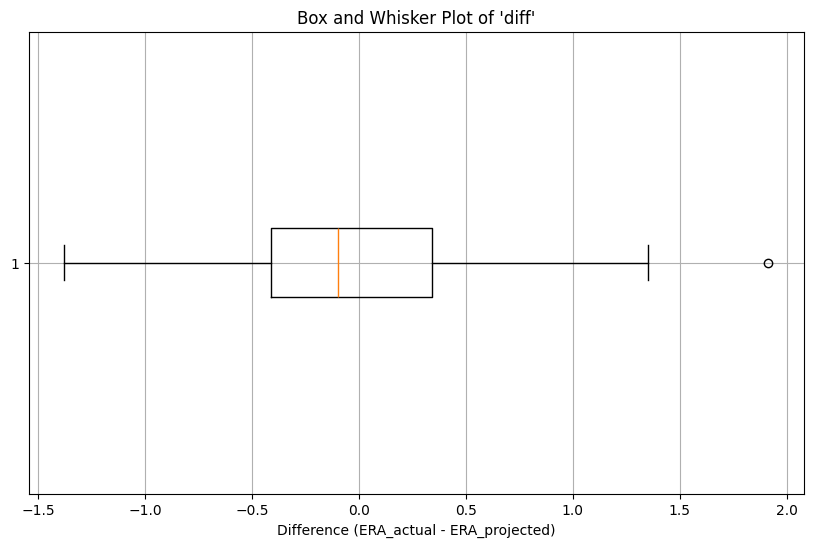

In [98]:
# Creating a box and whisker plot for the 'diff' column

plt.figure(figsize=(10, 6))
plt.boxplot(last_yr['diff'].dropna(), vert=False)  # Dropping NaN values for plotting
plt.title("Box and Whisker Plot of 'diff'")
plt.xlabel("Difference (ERA_actual - ERA_projected)")
plt.grid(True)
plt.show()


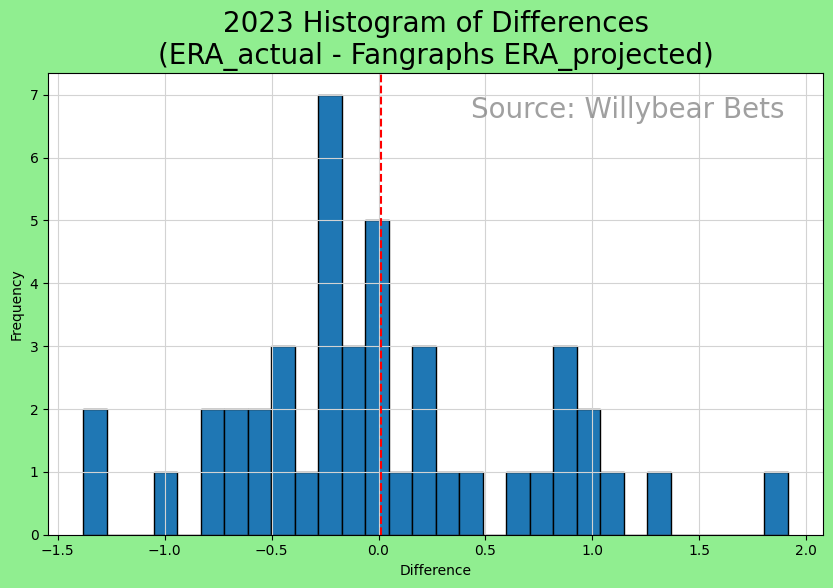

In [99]:
# Creating a histogram for the 'diff' column

plt.figure(figsize=(10, 6), facecolor='lightgreen')
plt.hist(last_yr['diff'].dropna(), bins=30, edgecolor='black')
plt.title("2023 Histogram of Differences\n(ERA_actual - Fangraphs ERA_projected)", fontsize = 20)
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.axvline(x = last_yr['diff'].mean(), color = 'red', label = 'axvline - full height', linestyle = '--')
plt.annotate(f"Mean Difference: {last_yr['diff'].mean():.2f}", xy=(last_yr['diff'].mean(), 14), xytext=(last_yr['diff'].mean()+.5, 13),
            arrowprops=dict(facecolor='black', shrink=0.05),fontsize=15
            )
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)
plt.grid(True, color = 'lightgrey')
plt.show()


# Lets build a monte carlo simulation to see what odds we have for the bovada players

The idea is this: if we know what the projected ERA's are for the players from ATC (the most accurate projections in the business), and we know the distribution of how much they miss by (i.e. Actual Results - Projected Results), then we can just sample from that distribution and add (or subtract it) to the 2024 projection. If we repeat this many, many times, we can see for each player what the probability is that the projection is greater than the Bovada line. 

Then, if Hunter Greene for example, has an X% probability of being greater than the Bovada line given his ATC projection, we can compare this to the implied probabilities. Bovada takes a rake off of the top. That is, even though the over and under are both paying out at -115, the probability of over and under is clearly 50% each. But, -115 has implied probability of 53.5%, meaning that in order to have an equal risk-reward balance, you would have to be 53.5% accurate with your predictions. In other words, Bovada is taking a 3.5% rake by changing these odds.

So, if X > 53.5 we should have positive EV and the greater X is, the more confident we should be in the bet, and the higher the EV should be.

In [100]:
merged = last_yr[['Name', 'ERA_actual', "ERA_projected", 'diff', 'Shortened_Name', 'IP_actual']].merge(yahoo_overs[['Player Name', 'ATC_ERA', "Over_Value"]], right_on = 'Player Name', left_on = 'Name', how = 'right')

In [101]:
# Lets see what the min value is for innings pitched of the people with ERA lines
# We will set this to be the threshhold for querying the data
merged['IP_actual'].min()

165.2

# We need two datasets, not merged

Step 1: Sample from ATC diffs

Step 2: Add this number to yahoo_overs['ATC_ERA']

Step 3: Check if this is greater than yahoo_overs['Over_Value']

Step 4: Repeat 1-3 many many times

Step 5: Aggregate results

# For graphing we want to get team colors

In [102]:
mlb_team_colors = {
    'ARI': '#A71930',  # Arizona Diamondbacks
    'ATL': '#CE1141',  # Atlanta Braves
    'BAL': '#DF4601',  # Baltimore Orioles
    'BOS': '#BD3039',  # Boston Red Sox
    'CHC': '#0E3386',  # Chicago Cubs
    'CWS': '#27251F',  # Chicago White Sox
    'CIN': '#C6011F',  # Cincinnati Reds
    'CLE': '#0C2340',  # Cleveland Guardians
    'COL': '#33006F',  # Colorado Rockies
    'DET': '#0C2340',  # Detroit Tigers
    'HOU': '#002D62',  # Houston Astros
    'KCR':  '#004687',  # Kansas City Royals
    'LAA': '#BA0021',  # Los Angeles Angels
    'LAD': '#005A9C',  # Los Angeles Dodgers
    'MIA': '#00A3E0',  # Miami Marlins
    'MIL': '#FFC52F',  # Milwaukee Brewers
    'MIN': '#002B5C',  # Minnesota Twins
    'NYM': '#FF5910',  # New York Mets
    'NYY': '#0C2340',  # New York Yankees
    'OAK': '#003831',  # Oakland Athletics
    'PHI': '#E81828',  # Philadelphia Phillies
    'PIT': '#FDB827',  # Pittsburgh Pirates
    'SDP':  '#2F241D',  # San Diego Padres
    'SEA': '#0C2C56',  # Seattle Mariners
    'SFG':  '#FD5A1E',  # San Francisco Giants
    'STL': '#C41E3A',  # St. Louis Cardinals
    'TBR':  '#092C5C',  # Tampa Bay Rays
    'TEX': '#003278',  # Texas Rangers
    'TOR': '#134A8E',  # Toronto Blue Jays
    'WSH': '#AB0003'   # Washington Nationals
}

mlb_team_colors_df = pd.DataFrame(list(mlb_team_colors.items()), columns=['Team', 'Color'])
yahoo_overs = pd.read_csv('over_lines.csv')
yahoo_overs= yahoo_overs.merge(mlb_team_colors_df, on = 'Team', how = 'left')

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Assuming last_yr and yahoo_overs are available as per the user's last code snippet
# Using mock data for demonstration purposes

# Define the number of simulations
N = 10000

# This function performs the Monte Carlo simulation for one player and returns both the over hit rate and simulated ERAs
def simulate_for_player(diff_data, atc_era, over_value, n_simulations):
    # Sample from the diffs and add to ATC_ERA to simulate ERAs
    simulated_eras = atc_era + np.random.choice(diff_data['diff'], size=n_simulations)
    # Check if the simulated ERA is greater than Over_Value
    over_hits = simulated_eras > over_value
    # Calculate the over hit rate
    over_hit_rate = np.mean(over_hits)
    return over_hit_rate, simulated_eras

# Adjusting the simulation to produce a single DataFrame that includes the team colors and over_value

# Perform the simulation for all players and store the results in a single DataFrame
simulation_results = []

for index, row in yahoo_overs.iterrows():
    player = row['Player Name']
    atc_era = row['ATC_ERA']
    over_value = row['Over_Value']
    team_color = row['Color']  # Assuming 'Color' is already in yahoo_overs

    # Get the over hit rate and simulated ERAs
    over_hit_rate, simulated_eras = simulate_for_player(last_yr, atc_era, over_value, N)

    # Store the simulated ERAs along with the player name, over hit rate, color, and Bovada line
    for era in simulated_eras:
        simulation_results.append((player, era, over_hit_rate, team_color, over_value))

# Convert to DataFrame
simulation_results_df = pd.DataFrame(simulation_results,
                                     columns=['Player Name', 'Simulated_ERA', 'Over_Hit_Rate', 'Color', 'Over_Value'])



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:181: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  figlegend = self._figure.legend(handles, labels, **kwargs)


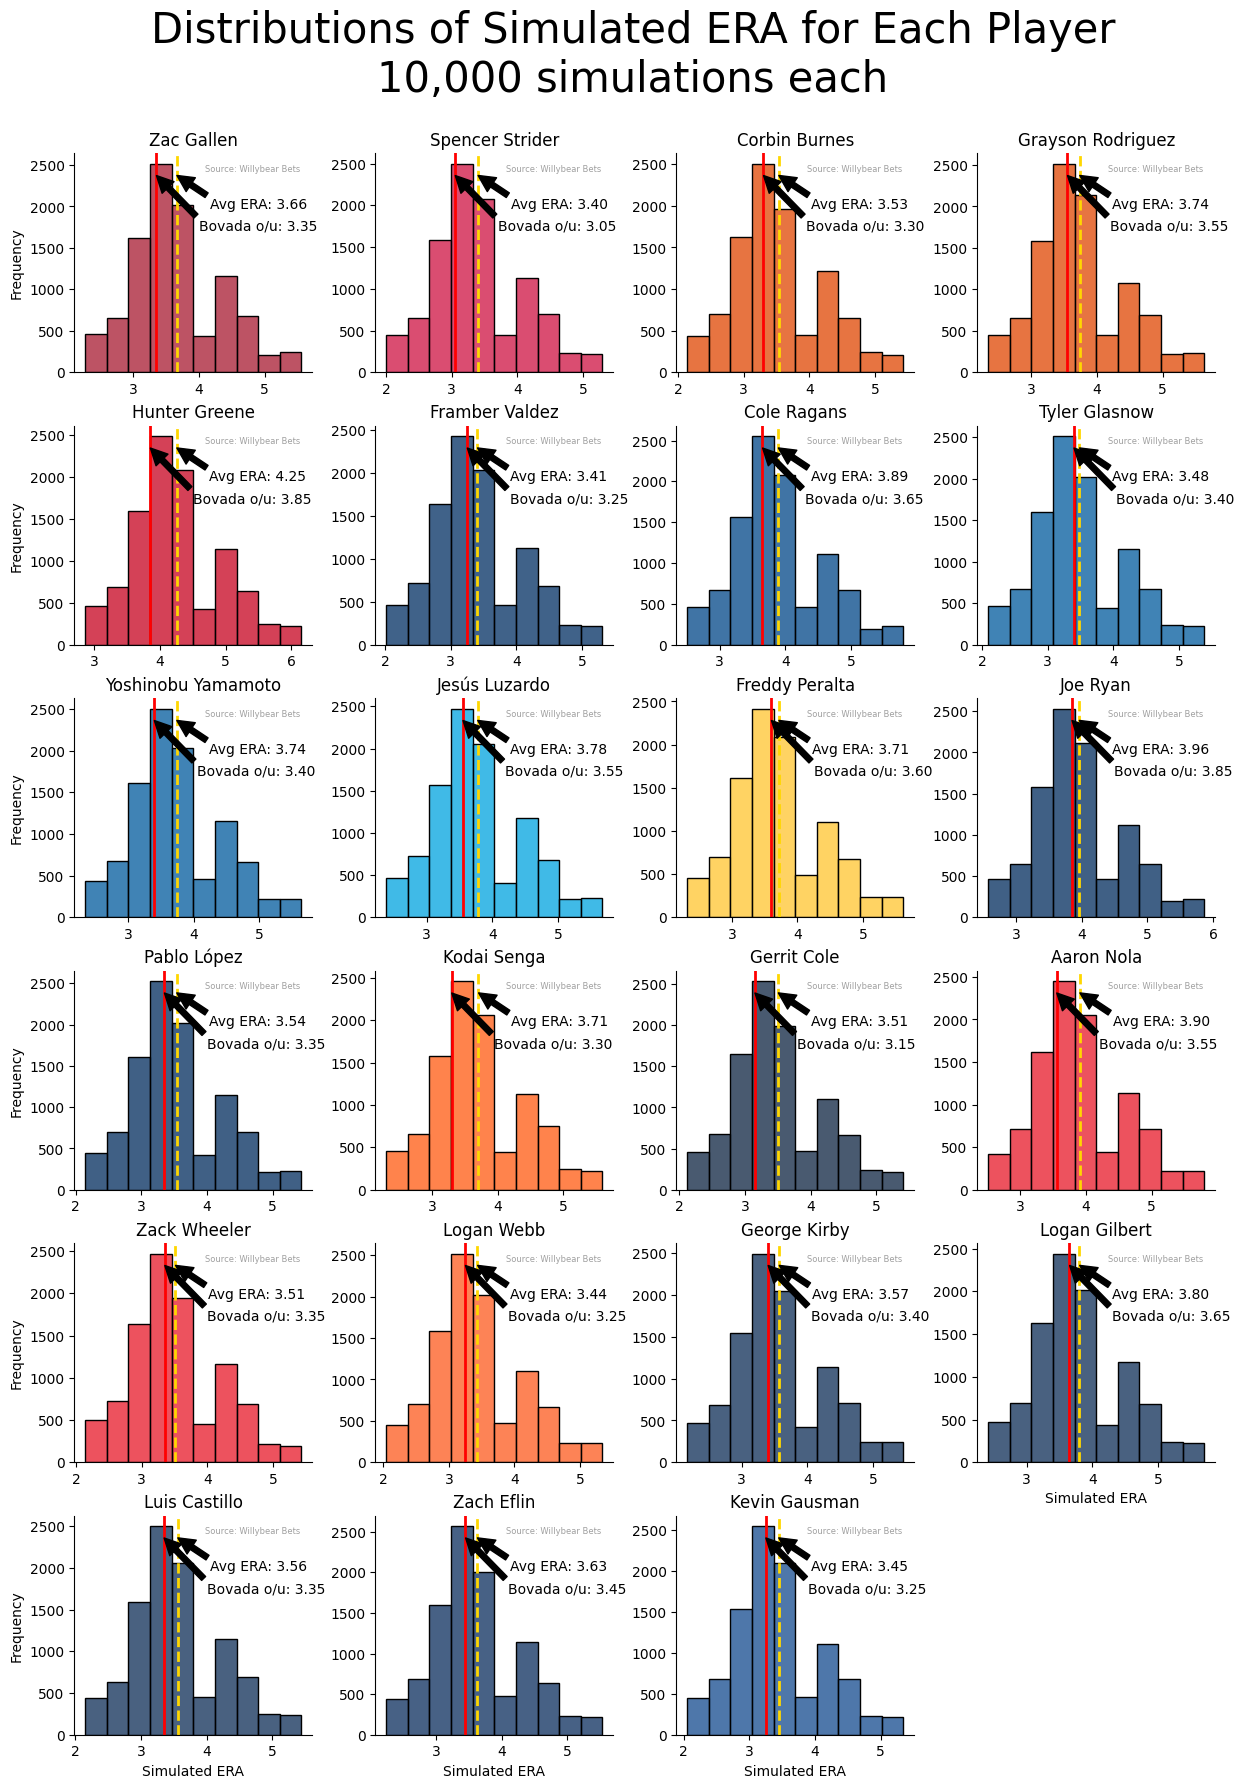

In [104]:
# Now let's plot the histogram for each player with the mean and Bovada line
# We'll create the FacetGrid with histograms and add the vertical lines within the loop
g = sns.FacetGrid(simulation_results_df, col="Player Name", col_wrap=4, sharex=False, sharey=False)

# Loop over each player in the FacetGrid
for ax, player_name in zip(g.axes.flatten(), simulation_results_df['Player Name'].unique()):
    # Filter the DataFrame for the current player
    player_data = simulation_results_df[simulation_results_df['Player Name'] == player_name]
    
    # Plot the histogram with the player's team color
    sns.histplot(player_data['Simulated_ERA'], color=player_data['Color'].iloc[0], ax=ax, bins=10)
    
    # Plot the mean as a gold dashed line
    mean_val = player_data['Simulated_ERA'].mean()
    ax.axvline(mean_val, color='gold', linestyle='--', linewidth=2)
    
    # Plot the Bovada line as a red solid line
    bovada_line = player_data['Over_Value'].iloc[0]
    ax.axvline(bovada_line, color='red', linestyle='-', linewidth=2)
    ax.annotate(f"Avg ERA: {mean_val:.2f}", xy=(mean_val, ax.get_ylim()[1]*0.9), 
                xytext=(mean_val + 0.5, ax.get_ylim()[1]*0.75),
                arrowprops=dict(facecolor='black', shrink=0.005), fontsize=10)
    ax.annotate(f"Bovada o/u: {bovada_line:.2f}", xy=(bovada_line, ax.get_ylim()[1]*0.9), 
                xytext=(bovada_line + 0.65, ax.get_ylim()[1]*0.65),
                arrowprops=dict(facecolor='black', shrink=0.005), fontsize=10)
    
    # Set the title for each subplot to the player's name
    ax.set_title(player_name)
    # Add watermark or annotation in the top right of each subplot
    ax.text(0.95, 0.95, "Source: Willybear Bets", transform=ax.transAxes, 
            ha='right', va='top', fontsize=6, color='gray', alpha=0.75)
# Set labels and titles
g.set_axis_labels('Simulated ERA', 'Frequency')
g.fig.suptitle('Distributions of Simulated ERA for Each Player\n10,000 simulations each', fontsize=30)
g.fig.subplots_adjust(top=0.9)  # Adjust to make space for the title

# Add legend manually
g.add_legend({'Mean ERA': 'gold', 'Bovada Line': 'red'})

# Display the FacetGrid
plt.show()

/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_35250/1575874760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barchart_data['ohr_perc'] = barchart_data['Over_Hit_Rate'] * 100


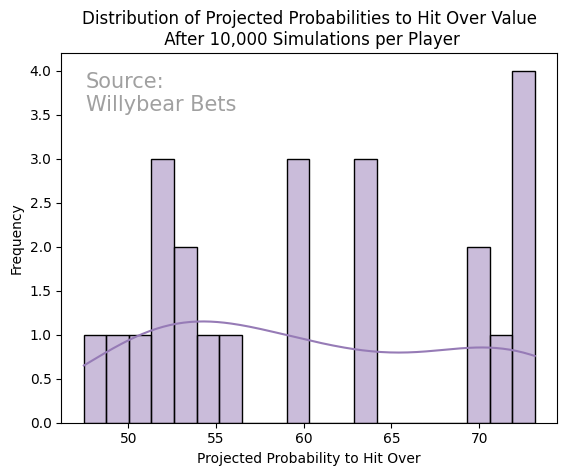

In [105]:
barchart_data = simulation_results_df.drop_duplicates('Player Name')
barchart_data['ohr_perc'] = barchart_data['Over_Hit_Rate'] * 100
# Next, we create the distribution graph of projected probabilities to hit (over_hit_rates)
sns.histplot(data=barchart_data, x='ohr_perc', bins=20, kde=True, color="#967bb6")
plt.title('Distribution of Projected Probabilities to Hit Over Value\n After 10,000 Simulations per Player')
plt.xlabel('Projected Probability to Hit Over')
plt.ylabel('Frequency')
plt.text(0.05, 0.95, "Source:\nWillybear Bets", transform=plt.gca().transAxes,
         ha='left', va='top', fontsize=15, color='gray', alpha=0.75)
plt.show()

In [106]:
yahoo_overs[yahoo_overs['Name'] == 'George Kirby']

,Unnamed: 0,Market Name,Outcome,Bet Price,Player Name,PlayerId,Name_x,Team,ATC_ERA,Depth_Charts_ERA,...,IP_y,W_y,SV_y,K_y,ERA_y,WHIP_y,yahoo_diff,mean_era_2,mean_diff_2,Color
18,18,Seattle Mariners - George Kirby ERA,Over 3.40,-115,George Kirby,25436,George Kirby,SEA,3.54876,3.5468,...,185.0,14.0,0.0,179.0,3.31,1.09,-0.09,3.508181,0.181454,#0C2C56


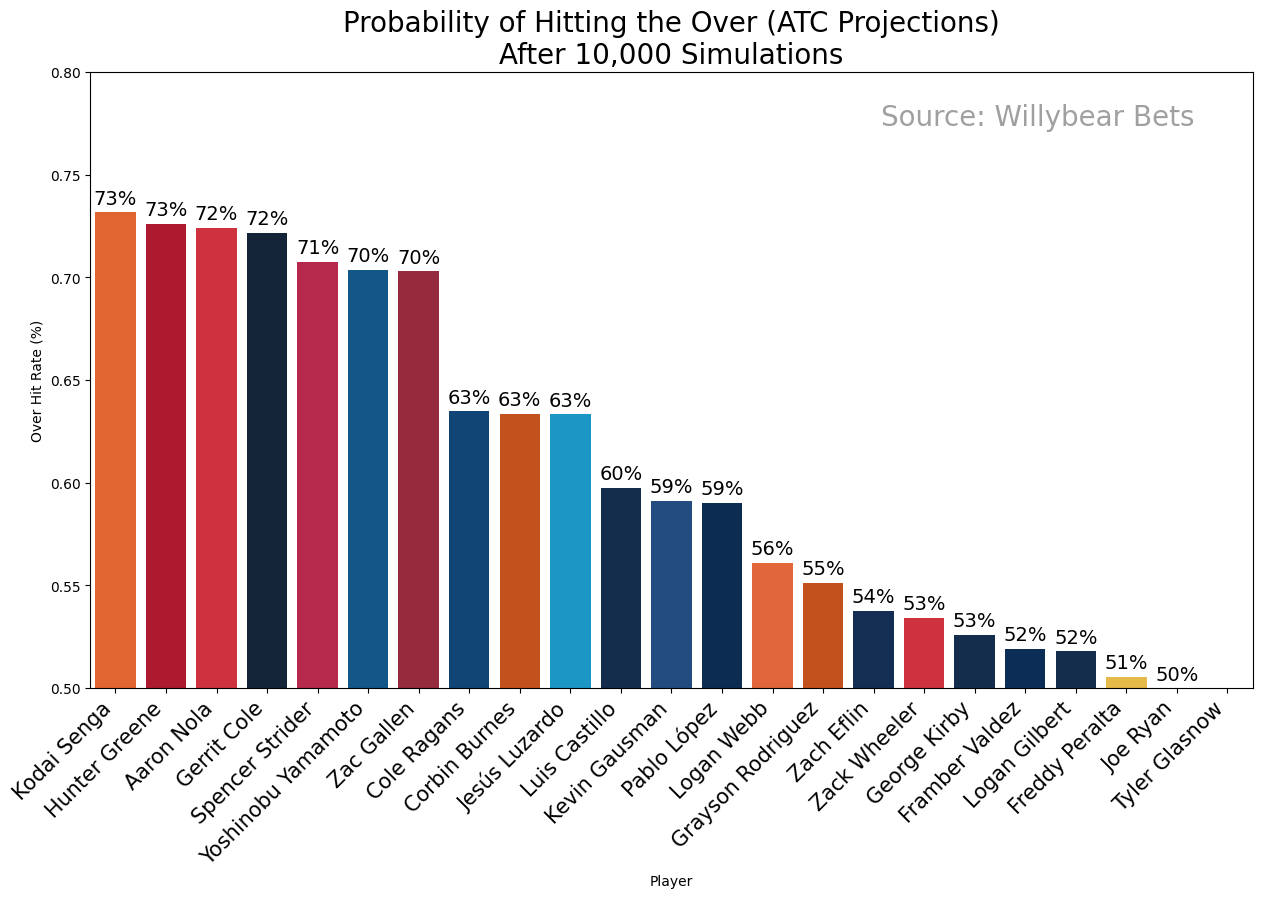

In [107]:
# Assuming the correct column name for players in both DataFrames is 'Player'
# We will merge the color information from 'yahoo_overs' to 'sorted_over_hit_rates_df' based on the player names

sorted_over_hit_rates_df = simulation_results_df.drop_duplicates('Player Name').sort_values(by='Over_Hit_Rate', ascending=False).reset_index(drop=True)
# Creating the bar chart with the updated color mapping
plt.figure(figsize=(15, 8))
barplot = sns.barplot(
    data=sorted_over_hit_rates_df,
    x='Player Name',
    y='Over_Hit_Rate',
    palette=sorted_over_hit_rates_df['Color']
)

# Adding the over hit rate as a percent on top of each bar
for p in barplot.patches:
    barplot.annotate(
        f"{p.get_height():.0%}",  # Format as percent
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        fontsize=14, color='black',
        xytext=(0, 10),
        textcoords='offset points'
    )

# Setting the labels and title
plt.xticks(rotation=45, ha='right', fontsize = 15)
plt.xlabel('Player')
plt.ylabel('Over Hit Rate (%)')
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)
plt.title('Probability of Hitting the Over (ATC Projections)\nAfter 10,000 Simulations', fontsize=20)
plt.ylim(.5, .8)
# Show the plot
plt.show()


In [108]:
sorted_over_hit_rates_df.columns



Index(['Player Name', 'Simulated_ERA', 'Over_Hit_Rate', 'Color', 'Over_Value'], dtype='object')

In [109]:
df = sorted_over_hit_rates_df.merge(over_lines[['Player Name', 'Bet Price']], on = 'Player Name')
df = df.copy()
df['Bet Price'] = df['Bet Price'].astype('int')
# Function to convert American odds to implied probability
def american_odds_to_implied_probability(odds):
    if odds < 0:
        return -odds / (-odds + 100)
    else:
        return 100 / (odds + 100)

# Apply the conversion to the dataframe
df['Implied Probability'] = df['Bet Price'].apply(american_odds_to_implied_probability)

# Calculate the difference
df['Diff'] = df['Over_Hit_Rate'] - df['Implied Probability']

,Player Name,Simulated_ERA,Over_Hit_Rate,Color,Over_Value,Bet Price,Implied Probability,Diff
2,Aaron Nola,3.468823,0.7240,#E81828,3.55,-115,0.534884,0.189116
1,Hunter Greene,4.152733,0.7259,#C6011F,3.85,-120,0.545455,0.180445
0,Kodai Senga,4.067575,0.7317,#FF5910,3.30,-125,0.555556,0.176144
4,Spencer Strider,2.801982,0.7075,#CE1141,3.05,-115,0.534884,0.172616
5,Yoshinobu Yamamoto,3.541832,0.7036,#005A9C,3.40,-115,0.534884,0.168716
3,Gerrit Cole,4.484576,0.7216,#0C2340,3.15,-125,0.555556,0.166044
6,Zac Gallen,3.230203,0.7030,#A71930,3.35,-125,0.555556,0.147444
7,Cole Ragans,3.471363,0.6348,#004687,3.65,-115,0.534884,0.099916
8,Corbin Burnes,3.751575,0.6336,#DF4601,3.30,-125,0.555556,0.078044
9,Jesús Luzardo,4.092221,0.6333,#00A3E0,3.55,-125,0.555556,0.077744


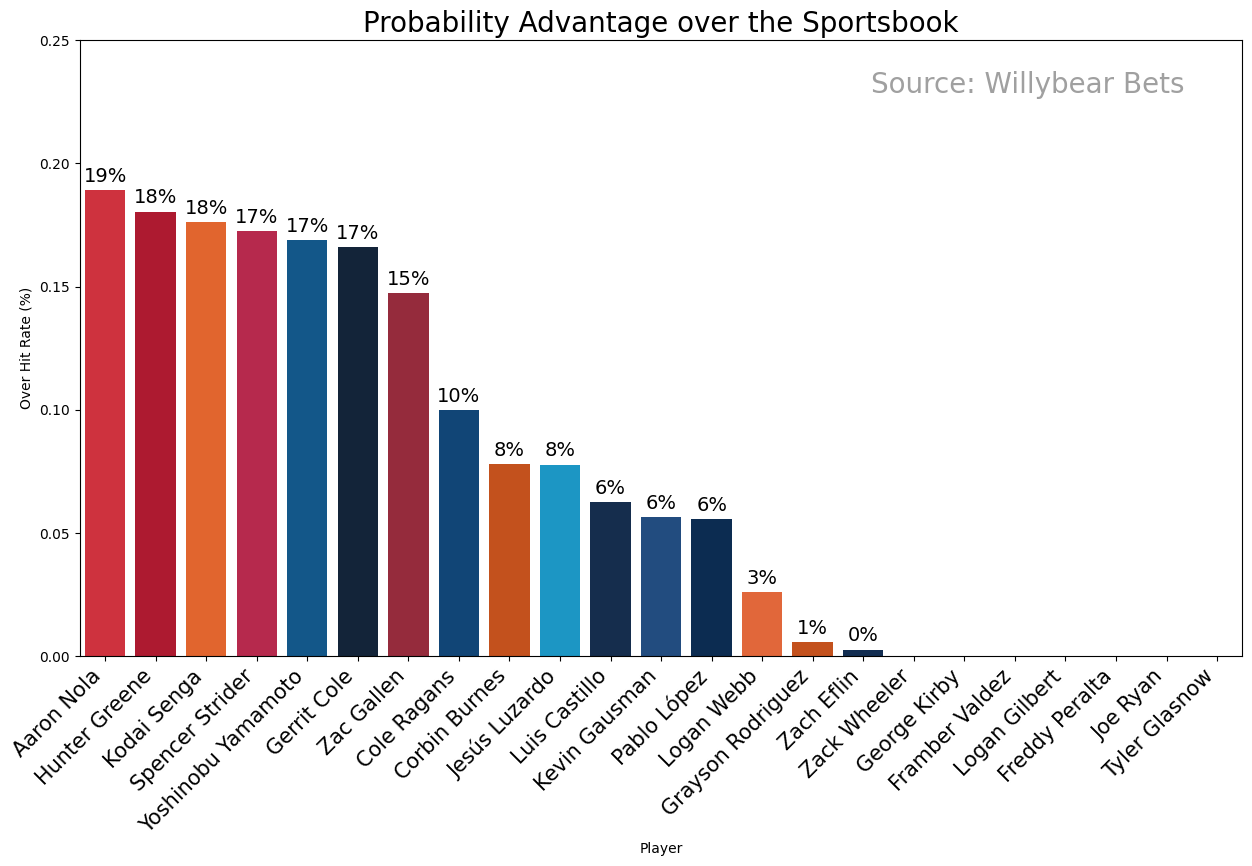

In [113]:
# Assuming the correct column name for players in both DataFrames is 'Player'
# We will merge the color information from 'yahoo_overs' to 'sorted_over_hit_rates_df' based on the player names

sorted_over_hit_rates_df2 = df.sort_values('Diff', ascending=False)
# Creating the bar chart with the updated color mapping
plt.figure(figsize=(15, 8))
barplot = sns.barplot(
    data=sorted_over_hit_rates_df2,
    x='Player Name',
    y='Diff',
    palette=sorted_over_hit_rates_df2['Color']
)

# Adding the over hit rate as a percent on top of each bar
for p in barplot.patches:
    barplot.annotate(
        f"{p.get_height():.0%}",  # Format as percent
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        fontsize=14, color='black',
        xytext=(0, 10),
        textcoords='offset points'
    )

# Setting the labels and title
plt.xticks(rotation=45, ha='right', fontsize = 15)
plt.xlabel('Player')
plt.ylabel('Over Hit Rate (%)')
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)
plt.title('Probability Advantage over the Sportsbook', fontsize=20)
plt.ylim(0, .25)
# Show the plot
plt.show()


# Is this the case for other statistics?

Lets investigate strikeouts and Wins as well

In [301]:
# Filter and rename ERA columns for each dataset
def filter_era(df, system_name):
    df = df[['PlayerId', 'Name', 'Team', 'W', 'SO']]
    df.columns = ['PlayerId', 'Name', 'Team', f'{system_name}_W', f'{system_name}_SO']
    return df

atc_filtered2 = filter_era(atc, 'ATC')
depth_charts_filtered2 = filter_era(depth_charts, 'Depth_Charts')
steamer_filtered2 = filter_era(steamer, 'Steamer')
bat_filtered2 = filter_era(bat, 'The_BAT')
zips_filtered2 = filter_era(zips, 'ZiPS')

# Concatenating the dataframes with an outer join to ensure all players are included
projection_dfs2 = [atc_filtered2, depth_charts_filtered2, steamer_filtered2, bat_filtered2, zips_filtered2]
all_projections2 = pd.concat(projection_dfs2)

# Grouping by player and aggregating the data
grouped_projections2 = all_projections2.groupby(['PlayerId', 'Name', 'Team']).mean().reset_index()

grouped_projections2.head()

,PlayerId,Name,Team,ATC_W,ATC_SO,Depth_Charts_W,Depth_Charts_SO,Steamer_W,Steamer_SO,The_BAT_W,The_BAT_SO,ZiPS_W,ZiPS_SO
0,10058,Tyler Matzek,ATL,2.08557,39.0262,3.0,56.0,2.8044,56.3030,1.41534,39.1611,2.0,47.0
1,10061,Brooks Raley,NYM,1.99458,64.1646,2.0,69.0,3.2507,66.7709,2.10208,62.7839,1.0,50.0
2,10078,Caleb Thielbar,MIN,3.44080,63.6174,4.0,71.0,3.2706,72.7234,1.92629,64.6124,3.0,46.0
3,10123,Kyle Gibson,STL,10.33290,136.2780,10.0,138.0,10.8502,140.8740,9.49490,125.3020,8.0,119.0
4,10131,Stephen Strasburg,WSN,NaN,NaN,NaN,NaN,0.0475,0.7590,NaN,NaN,5.0,87.0


## Strikeouts Analysis

In [303]:
# Filter MLB data for ERA lines
strikeout_lines = mlb_data[mlb_data['Market Name'].str.contains('Total Strikeouts')]

# Extract player names from the 'Market Name' column
strikeout_lines['Player Name'] = strikeout_lines['Market Name'].str.extract(' - (.*) Total Strikeouts')

# Join the ERA lines with the projections
# Merging on 'Name' from projections and 'Player Name' from era_lines
final_data2 = pd.merge(strikeout_lines, grouped_projections2, left_on='Player Name', right_on='Name', how='left')

final_data2 = final_data2[~(final_data2['The_BAT_SO']).isna()]
final_data2.head()

/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_73690/1521495080.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strikeout_lines['Player Name'] = strikeout_lines['Market Name'].str.extract(' - (.*) Total Strikeouts')


,Market Name,Outcome,Bet Price,Player Name,PlayerId,Name,Team,ATC_W,ATC_SO,Depth_Charts_W,Depth_Charts_SO,Steamer_W,Steamer_SO,The_BAT_W,The_BAT_SO,ZiPS_W,ZiPS_SO
0,Arizona Diamondbacks - Merrill Kelly Total Str...,Over 170.5,-115,Merrill Kelly,11156,Merrill Kelly,ARI,11.3563,170.245,11.0,166.0,11.0501,175.977,9.89376,152.862,9.0,132.0
1,Arizona Diamondbacks - Merrill Kelly Total Str...,Under 170.5,-115,Merrill Kelly,11156,Merrill Kelly,ARI,11.3563,170.245,11.0,166.0,11.0501,175.977,9.89376,152.862,9.0,132.0
2,Arizona Diamondbacks - Zac Gallen Total Strike...,Over 192.5,-115,Zac Gallen,19291,Zac Gallen,ARI,12.7369,191.893,13.0,194.0,12.3759,202.589,11.58460,174.816,13.0,175.0
3,Arizona Diamondbacks - Zac Gallen Total Strike...,Under 192.5,-115,Zac Gallen,19291,Zac Gallen,ARI,12.7369,191.893,13.0,194.0,12.3759,202.589,11.58460,174.816,13.0,175.0
4,Atlanta Braves - Charlie Morton Total Strikeouts,Over 170.5,-115,Charlie Morton,4676,Charlie Morton,ATL,10.8151,162.687,12.0,179.0,11.4353,177.956,10.32530,165.668,12.0,166.0


In [304]:
# Filter the final data to include only 'Over' outcomes
over_lines2 = final_data2[final_data2['Outcome'].str.contains('Over')]

# Extracting the numerical value from the 'Outcome' column (e.g., "Over 3.35" -> 3.35)
over_lines2['Over_Value'] = over_lines2['Outcome'].str.extract('Over (.*)').astype(float)

# Calculating the mean projection ERA for each player
over_lines2['Mean_Projection_SO'] = over_lines2[['ATC_SO', 'Depth_Charts_SO', 'Steamer_SO', 'The_BAT_SO', 'ZiPS_SO']].mean(axis=1)

# Calculating the difference between the projection and the line
over_lines2['Difference'] = over_lines2['Mean_Projection_SO'] - over_lines2['Over_Value']



/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_73690/4068372989.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_lines2['Over_Value'] = over_lines2['Outcome'].str.extract('Over (.*)').astype(float)
/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_73690/4068372989.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_lines2['Mean_Projection_SO'] = over_lines2[['ATC_SO', 'Depth_Charts_SO', 'Steamer_SO', 'The_BAT_SO', 'ZiPS_SO']].mean(axis=1)
/var/folders/64/kktgr_017td3vw1nnvp

In [305]:
# Calculating the mean and median of the projections in separate columns
over_lines2['mean_diff'] = over_lines2['Mean_Projection_SO'] - over_lines2['Over_Value']
# Shortening player names to format 'Z. Gallen'
over_lines2['Shortened_Name'] = over_lines2['Player Name'].str.split().apply(lambda x: f"{x[0][0]}. {' '.join(x[1:])}")


/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_73690/2091407498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_lines2['mean_diff'] = over_lines2['Mean_Projection_SO'] - over_lines2['Over_Value']
/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_73690/2091407498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_lines2['Shortened_Name'] = over_lines2['Player Name'].str.split().apply(lambda x: f"{x[0][0]}. {' '.join(x[1:])}")


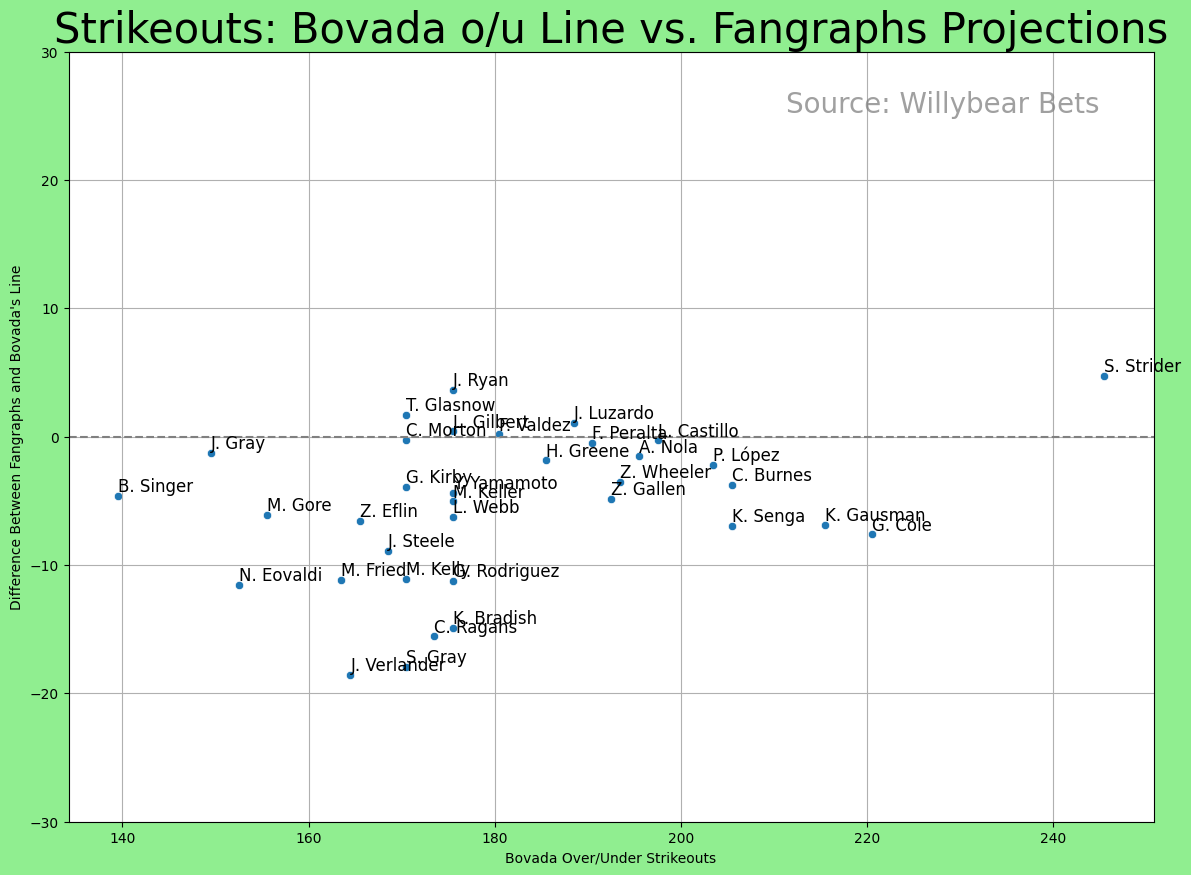

In [416]:
# Adjusting the plot to be horizontal for better visualization of differentials
plt.figure(figsize=(14, 10), facecolor='lightgreen')
sns.scatterplot(data=over_lines2, y='mean_diff', x='Over_Value')
plt.title('Strikeouts: Bovada o/u Line vs. Fangraphs Projections', fontsize = 30)
plt.ylabel("Difference Between Fangraphs and Bovada's Line")
plt.xlabel('Bovada Over/Under Strikeouts')
plt.ylim(-30, 30)
plt.axhline(0, color='grey', ls='--')  # Adding a horizontal reference line at y=0
plt.grid(True)
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)
# Annotating each point with the player's shortened name
for index, row in over_lines2.iterrows():
    plt.text(row['Over_Value'] + .005, row['mean_diff'] +.005, row['Shortened_Name'], verticalalignment='bottom', size='large', color='black')

plt.show()

## Wins Analysis

In [313]:
# Filter MLB data for ERA lines
win_lines = mlb_data[mlb_data['Market Name'].str.contains('Total Wins')]

# Extract player names from the 'Market Name' column
win_lines['Player Name'] = win_lines['Market Name'].str.extract(' - (.*) Total Wins')

# Join the ERA lines with the projections
# Merging on 'Name' from projections and 'Player Name' from era_lines
final_data3 = pd.merge(win_lines, grouped_projections2, left_on='Player Name', right_on='Name', how='left')

final_data3 = final_data3[~(final_data3['The_BAT_W']).isna()]
final_data3.head()

/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_73690/3083841371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_lines['Player Name'] = win_lines['Market Name'].str.extract(' - (.*) Total Wins')


,Market Name,Outcome,Bet Price,Player Name,PlayerId,Name,Team,ATC_W,ATC_SO,Depth_Charts_W,Depth_Charts_SO,Steamer_W,Steamer_SO,The_BAT_W,The_BAT_SO,ZiPS_W,ZiPS_SO
0,Arizona Diamondbacks - Zac Gallen Total Wins,Over 11.5,-115,Zac Gallen,19291,Zac Gallen,ARI,12.7369,191.893,13.0,194.0,12.3759,202.589,11.5846,174.816,13.0,175.0
1,Arizona Diamondbacks - Zac Gallen Total Wins,Under 11.5,-115,Zac Gallen,19291,Zac Gallen,ARI,12.7369,191.893,13.0,194.0,12.3759,202.589,11.5846,174.816,13.0,175.0
2,Atlanta Braves - Charlie Morton Total Wins,Over 11.5,-115,Charlie Morton,4676,Charlie Morton,ATL,10.8151,162.687,12.0,179.0,11.4353,177.956,10.3253,165.668,12.0,166.0
3,Atlanta Braves - Charlie Morton Total Wins,Under 11.5,-115,Charlie Morton,4676,Charlie Morton,ATL,10.8151,162.687,12.0,179.0,11.4353,177.956,10.3253,165.668,12.0,166.0
4,Atlanta Braves - Spencer Strider Total Wins,Over 15.5,-115,Spencer Strider,27498,Spencer Strider,ATL,15.2380,250.554,15.0,256.0,14.6132,257.091,14.3392,253.528,15.0,234.0


In [315]:
# Filter the final data to include only 'Over' outcomes
over_lines3 = final_data3[final_data3['Outcome'].str.contains('Over')]

# Extracting the numerical value from the 'Outcome' column (e.g., "Over 3.35" -> 3.35)
over_lines3['Over_Value'] = over_lines3['Outcome'].str.extract('Over (.*)').astype(float)

# Calculating the mean projection ERA for each player
over_lines3['Mean_Projection_W'] = over_lines3[['ATC_W', 'Depth_Charts_W', 'Steamer_W', 'The_BAT_W', 'ZiPS_W']].mean(axis=1)

# Calculating the difference between the projection and the line
over_lines3['mean_diff'] = over_lines3['Mean_Projection_W'] - over_lines3['Over_Value']
over_lines3['Shortened_Name'] = over_lines3['Player Name'].str.split().apply(lambda x: f"{x[0][0]}. {' '.join(x[1:])}")


/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_73690/3542124473.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_lines3['Over_Value'] = over_lines3['Outcome'].str.extract('Over (.*)').astype(float)
/var/folders/64/kktgr_017td3vw1nnvpfz4hw0000gn/T/ipykernel_73690/3542124473.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_lines3['Mean_Projection_W'] = over_lines3[['ATC_W', 'Depth_Charts_W', 'Steamer_W', 'The_BAT_W', 'ZiPS_W']].mean(axis=1)
/var/folders/64/kktgr_017td3vw1nnvpfz4hw0

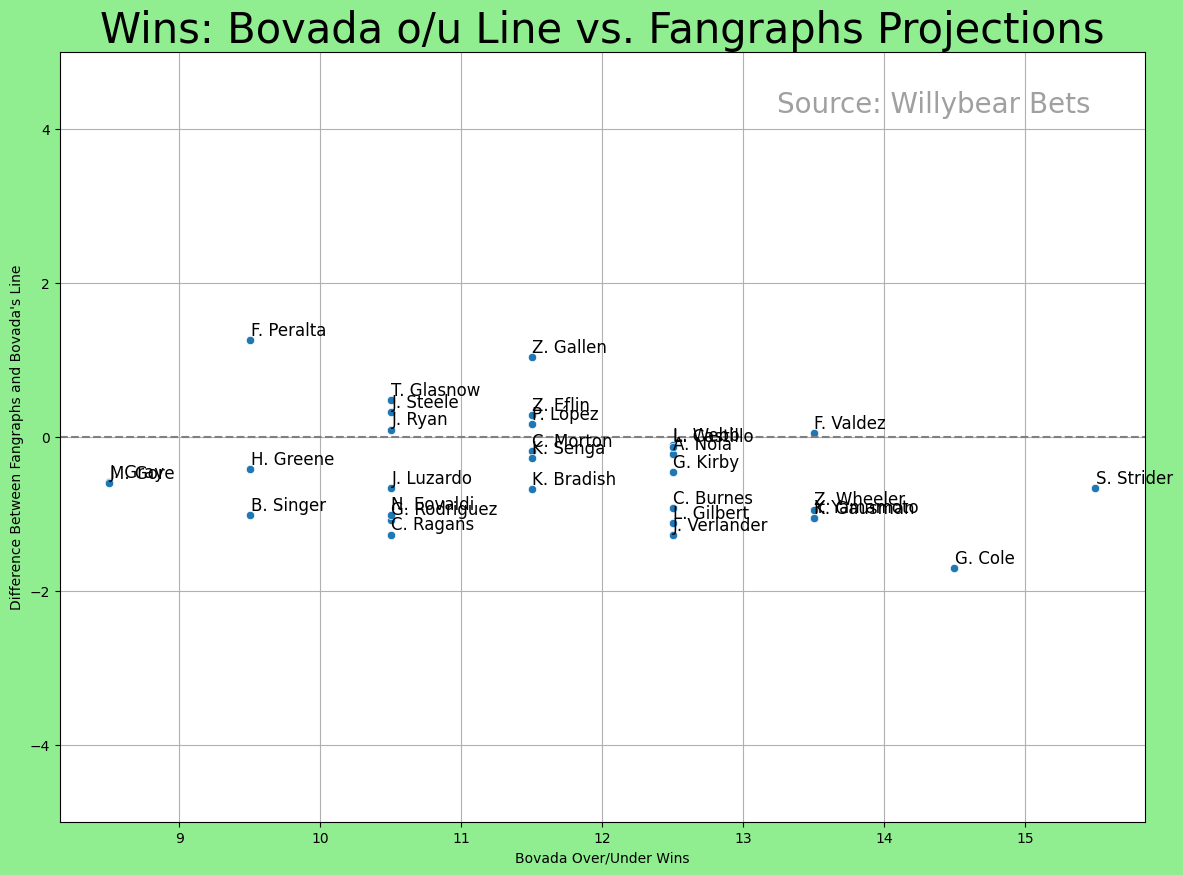

In [417]:
# Adjusting the plot to be horizontal for better visualization of differentials
plt.figure(figsize=(14, 10), facecolor='lightgreen')
sns.scatterplot(data=over_lines3, y='mean_diff', x='Over_Value')
plt.title('Wins: Bovada o/u Line vs. Fangraphs Projections', fontsize = 30)
plt.ylabel("Difference Between Fangraphs and Bovada's Line")
plt.xlabel('Bovada Over/Under Wins')
plt.ylim(-5, 5)
plt.axhline(0, color='grey', ls='--')  # Adding a horizontal reference line at y=0
plt.grid(True)
plt.text(0.95, 0.95, "Source: Willybear Bets", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=20, color='gray', alpha=0.75)
# Annotating each point with the player's shortened name
for index, row in over_lines3.iterrows():
    plt.text(row['Over_Value'] + .005, row['mean_diff'] +.005, row['Shortened_Name'], verticalalignment='bottom', size='large', color='black')

plt.show()